In [2]:
# Generic F2O imports
import F2O.F2O_utils as F2O

# F2O 'utils' for reading / ploting images
from F2O.imgUtils.image_utils import ImgPlot, ImgRead

# F2O 'utils' for (i) adding noise, (ii) collecting image metrics and (iii) applying the forward model 
from F2O.imgUtils.image_utils import ImgMetrics, ImgApplyFwNoise
from F2O.noise.noiseModels import noiseModels

# Other packages
import matplotlib.pylab as PLT
import numpy as np

# If you get an error while loading the F2O, then
# 
# * Exit Jupyter
# * Go to the F2O root dir, and execute
#      export PYTHONPATH=$PYTHONPATH:`pwd`
# * Relaunch Jupyter

No module named 'pyopencl'. cl12 version by Christoph Gohlke for windows is recommended: https://www.lfd.uci.edu/~gohlke/pythonlibs/#pyopencl


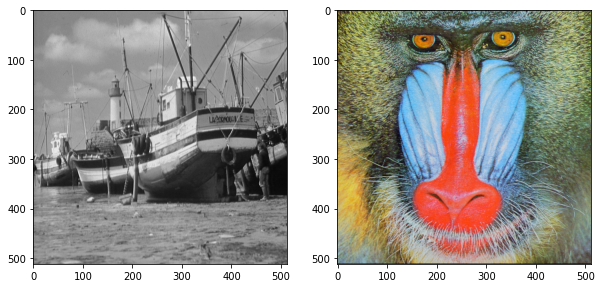

In [3]:
# Imports needed to read images from an URL address
import requests
from io import BytesIO

# Define an 'F2O-image' object 
testImgs = ImgRead()
        
# Test images from the SIPI image database
fname = {0: requests.get('http://sipi.usc.edu/database/misc/5.2.10.tiff'),   # bridge (grayscale)
         1: requests.get('http://sipi.usc.edu/database/misc/boat.512.tiff'), # boat (grayscale)
         2: requests.get('http://sipi.usc.edu/database/misc/4.2.03.tiff'),   # mandrill (color)
        }

testImgs.list.append([BytesIO(fname.get(1).content),'g'])
testImgs.list.append([BytesIO(fname.get(2).content),'c'])

u = testImgs.readListImgs()   # read list of images, normalize them between 0 and 1

pltImg  = ImgPlot()
pltImg.plotNImgs(u, len(u), None, 5)

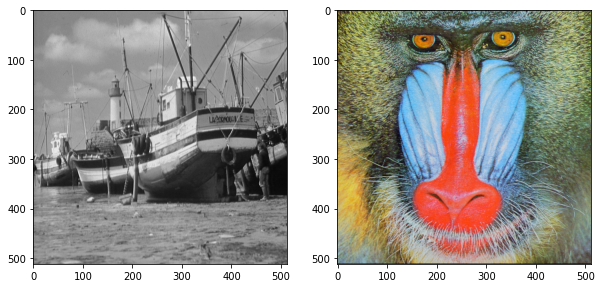

In [4]:
# Noise model

noise = noiseModels(model=F2O.f2oDef.noise_Gaussian, sigma=0.0)
addNoise = noise.sel_NoiseModel()

uObs = addNoise(u)

pltImg  = ImgPlot()
pltImg.plotNImgs(uObs, len(u), None, 5)

In [5]:
uLP, uHP = testImgs.computeLPHP( uObs[0] , padFlag=True)



In [6]:
uHP.shape

(512, 512, 1)

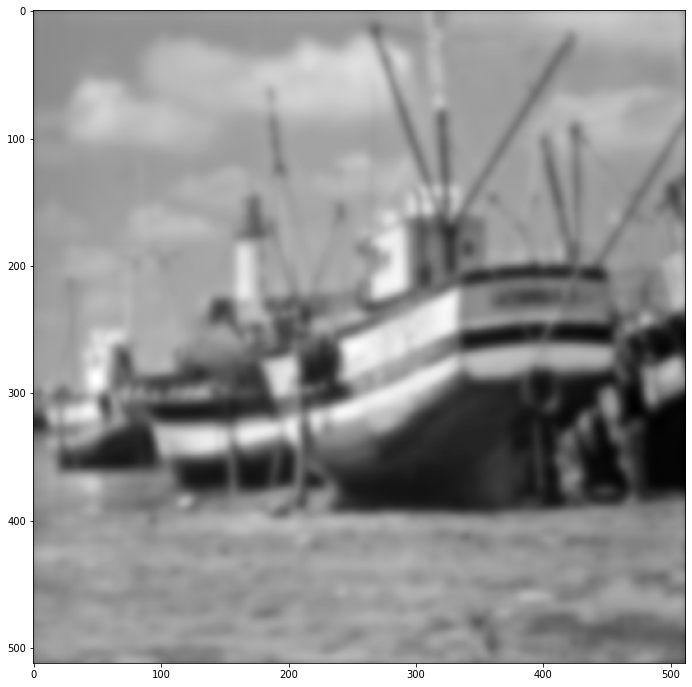

In [7]:
pltImg  = ImgPlot()
pltImg.plotNImgs(uObs[0]-uHP[:,:,0], 1, None, 12)


In [8]:


from F2O.fwOp.fwOperator import conv2DOp, fwOp_f
from F2O.PG_freq import apg as fAPG

import scipy.io as sio

import os

os.getcwd()

'/home/jaru/mySims/F2Otree/f2oDocs/docs/source/notebooks'

In [9]:
# Pre-computed dictionary
Dict = sio.loadmat('./data/nsp_36x36x12.mat')  
H = Dict['FB']


argsF = F2O.argsF2O()

argsF.verbose         = True
argsF.fCostClass      = argsF.f2oDef.cost_L2L1_lin   # F(x) = 0.5|| Op(x) - b ||_2^2 + \lambda||x||_1, 
                                                     # where Op(.) is linear
argsF.padFlag         = True
argsF.padMode         = 'symmetric'

# Select frequency domain routines
freqOp         = fwOp_f(linOp=argsF.f2oDef.fAx_FB2D, A=H)

freqOp.label     = "nsp_36x36x12"
freqOp.vecFlag   = True            # input / output data are asumed / force to be vectorized


In [10]:
# -----------------------------------------------  
# --- FISTA (frequency) + Cauchy lagged
# -----------------------------------------------

argsF.ssPoliciy  = argsF.f2oDef.ss_CauchyLagged     # step-size policiy
argsF.ISeqPolicy = argsF.f2oDef.iseq_ntrv          # inertial sequence


lmbda = 0.01
nIter = 40

x, Stats = fAPG(freqOp, uHP, lmbda, nIter, argsF)





Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 1.465e+03	 5.24e-03    2.03e+00    nan
  1	 2.607e+02	 5.24e-03    2.24e+00    2.654e-01
  2	 1.541e+02	 5.08e-03    2.52e+00    1.398e-01
  3	 1.200e+02	 5.08e-03    2.74e+00    1.022e-01
  4	 1.071e+02	 4.65e-03    2.97e+00    7.757e-02
  5	 9.654e+01	 4.65e-03    3.20e+00    6.392e-02
  6	 9.082e+01	 5.63e-03    3.42e+00    6.043e-02
  7	 8.651e+01	 5.63e-03    3.64e+00    5.827e-02
  8	 8.405e+01	 4.60e-03    3.86e+00    5.114e-02
  9	 8.031e+01	 4.60e-03    4.09e+00    4.520e-02
 10	 7.795e+01	 5.98e-03    4.31e+00    4.443e-02
 11	 7.614e+01	 5.98e-03    4.54e+00    4.431e-02
 12	 7.514e+01	 4.65e-03    4.76e+00    4.054e-02
 13	 7.305e+01	 4.65e-03    4.98e+00    3.699e-02
 14	 7.158e+01	 5.90e-03    5.20e+00    3.660e-02
 15	 7.048e+01	 5.90e-03    5.43e+00    3.677e-02
 16	 6.987e+01	 4.71e-03    5.65e+00    3.458e-02
 17	 6.848e+01	 4.71e-03    5.87e+00    3.231e-02
 18	 6.742e+01	 5.65e-03    6.10e+00    3.192e-02


In [11]:
z = argsF.getROI(x)
z.shape
x.shape

(536, 269, 1, 36)

In [12]:
recHP0 = freqOp.fRec(x)
recHP1 = freqOp.fRec(x,getROI=argsF.getROI)

uRec = freqOp.fRec(x, uLP, getROI=argsF.getROI )       # uRec = fwOp(x) + uLP

(536, 536)


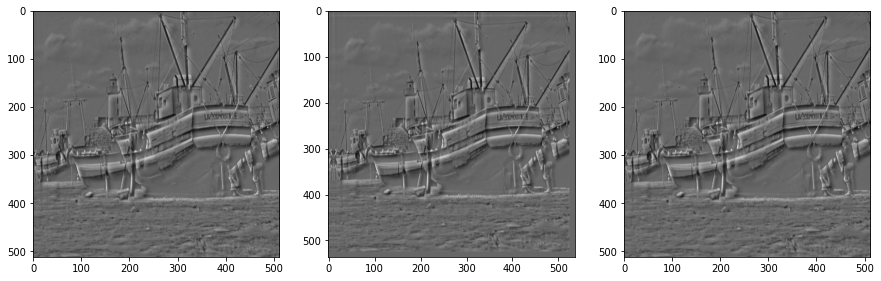

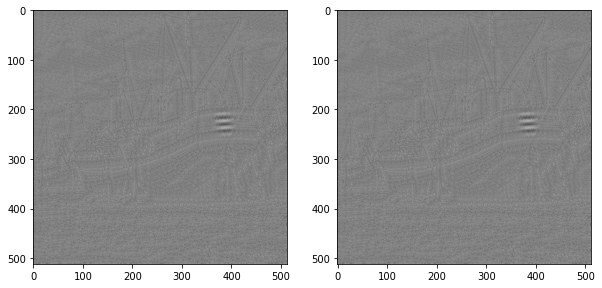

In [32]:
img = []
img.append(argsF.f2oJax.getDataOut(uHP))
img.append(argsF.f2oJax.getDataOut(recHP0))
img.append(argsF.f2oJax.getDataOut(recHP1))


print(recHP0.shape)

pltImg  = ImgPlot()
pltImg.plotNImgs(img, len(img), None, 5)

dImg = []
dImg.append(img[0] - img[2])
dImg.append(img[0] - img[1][12:512+12,12:512+12])

pltImg  = ImgPlot()
pltImg.plotNImgs(dImg, len(dImg), None, 5)



In [14]:
L=12
print(np.linalg.norm( img[0] - img[1][L:512+L,L:512+L] ))

4.336843


In [15]:
argsF.padMode

'symmetric'

In [16]:
argsF.padOffset

(12, 12)

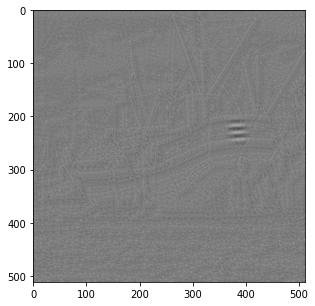

In [17]:
pltImg  = ImgPlot()
pltImg.plotNImgs(uRec[:,:,0]-uObs[0], 1, None, 5)


In [23]:
imgs = []
uRec = freqOp.fRec(x, uLP, getROI=argsF.getROI )
imgs.append(uRec)
imgs.append(np.squeeze(uRec)-uObs)

txt = []
txt.append('Reconstructed')
txt.append('Difference {:1.2f}'.format(np.linalg.norm(uRec.ravel() - uObs.ravel()) ) )

pltImg  = ImgPlot()
pltImg.plotNImgs(imgs, len(imgs), txt, 5)

ValueError: could not broadcast input array from shape (512,3) into shape (512)

In [19]:
uRec.shape


(512, 512, 1)

In [26]:
np.squeeze(uRec) - uObs[0]

DeviceArray([[-1.0420829e-02, -2.2619665e-03, -4.7425032e-03, ...,
               7.2586536e-04, -9.8354220e-03, -6.4318180e-03],
             [-3.1653643e-03, -2.2783875e-04, -5.0584078e-03, ...,
               9.4711781e-04, -1.9013882e-04, -7.0810318e-05],
             [-7.9834163e-03,  6.6682100e-03, -3.0443370e-03, ...,
              -2.5697291e-02,  2.0076334e-02, -2.4022818e-02],
             ...,
             [-9.1168284e-04,  1.5568733e-03,  1.2660742e-02, ...,
              -1.9338727e-04, -3.4777820e-03, -4.5653880e-03],
             [ 2.0900369e-03,  3.8321316e-03, -1.8320680e-03, ...,
              -5.7832301e-03,  1.2131542e-02, -1.4257997e-02],
             [-8.6861551e-03, -3.7053227e-04, -1.4932334e-02, ...,
              -1.1161238e-02, -3.5662353e-03, -1.2926817e-02]],            dtype=float32)

In [29]:
np.linalg.norm(uRec[15:500,15:500,0] - uObs[0][15:500,15:500])

4.121088